In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from torchvision import datasets,transforms 
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np 
import torch 

num_workers = 0
batch_sizes = 32
valid_size = 0.2 

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
traindata = datasets.CIFAR10(root='CIFAR_10', download=True, train=True, transform = train_transform)
testdata = datasets.CIFAR10(root='CIFAR_10', download=True, train=False, transform = test_transform)

num_train = len(traindata)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(num_train*valid_size))
train_idx, valid_idx = indices[split:], indices[:split]
# print(train_idx)
train_sampler, valid_sampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(traindata, sampler=train_sampler, batch_size=batch_sizes, num_workers=num_workers)
validloader = torch.utils.data.DataLoader(traindata, sampler=valid_sampler, batch_size=batch_sizes, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testdata, batch_size=batch_sizes, num_workers=num_workers)


Files already downloaded and verified
Files already downloaded and verified


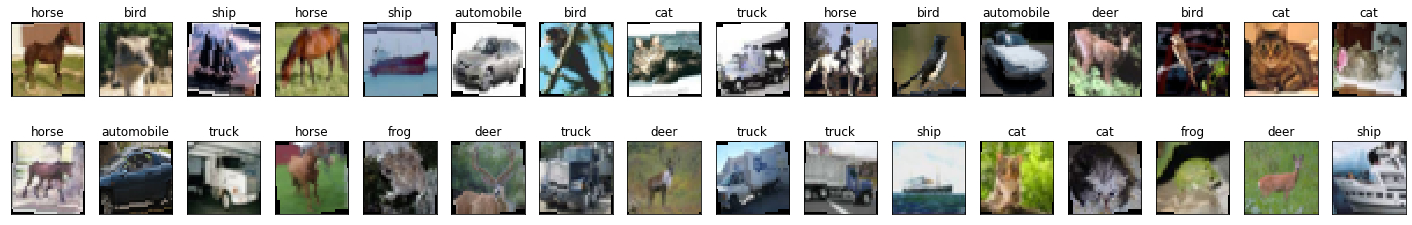

In [3]:
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
dataiter = iter(trainloader)
images, labels = dataiter.next()

# helper function to un-normalize and display an image
def imshow(img):

    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(32):
    ax = fig.add_subplot(2, 32/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [4]:
from torchvision import models 
import torch.nn as nn 

model = models.densenet161(pretrained=True)

classifier = nn.Sequential(nn.Linear(2208, 500),
                           nn.ReLU(),
                           nn.Dropout(0.2),
                           nn.Linear(500, 10),
                           nn.LogSoftmax(dim=1)
                            )
model.classifier = classifier

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [5]:
import torch.optim as optim 
from tqdm import tqdm 

for param in model.features.parameters():
  param.required_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
EPOCHS = 10

valid_loss_min = np.Inf 

for epoch in range(EPOCHS):

  train_loss = 0.0
  valid_loss = 0.0

  model.train()
  for images, labels in tqdm(trainloader):
    
    optimizer.zero_grad()
    # print(images.shape)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images).to(device)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  
  model.eval()
  with torch.no_grad():

    for images, labels in tqdm(validloader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images).to(device)
      loss = criterion(outputs, labels)
      valid_loss += loss.item()
  
  train_loss = train_loss/len(trainloader)
  valid_loss = valid_loss/len(validloader)

  print('\nEPOCH : {}\t Training loss : {:.3f} \t Validation loss : {:.3f}. '.format(epoch+1, train_loss, valid_loss))

  if valid_loss < valid_loss_min:
    print('Validation loss decreased ({:.3f} --> {:.3f}) . Saving model ...\n'.format(valid_loss_min, valid_loss))
    valid_loss_min = valid_loss 
    torch.save(model.state_dict(), 'model.pt')
  



  0%|          | 0/1250 [00:00<?, ?it/s]


EPOCH : 1	 Training loss : 1.161 	 Validation loss : 0.690. 
Validation loss decreased (inf --> 0.690) . Saving model ...



  0%|          | 0/1250 [00:00<?, ?it/s]


EPOCH : 2	 Training loss : 0.699 	 Validation loss : 0.606. 
Validation loss decreased (0.690 --> 0.606) . Saving model ...



  0%|          | 0/1250 [00:00<?, ?it/s]


EPOCH : 3	 Training loss : 0.557 	 Validation loss : 0.522. 
Validation loss decreased (0.606 --> 0.522) . Saving model ...



100%|██████████| 313/313 [00:15<00:00, 20.92it/s]



EPOCH : 4	 Training loss : 0.474 	 Validation loss : 0.486. 
Validation loss decreased (0.522 --> 0.486) . Saving model ...



  0%|          | 0/1250 [00:00<?, ?it/s]


EPOCH : 5	 Training loss : 0.422 	 Validation loss : 0.473. 
Validation loss decreased (0.486 --> 0.473) . Saving model ...



100%|██████████| 313/313 [00:15<00:00, 21.12it/s]



EPOCH : 6	 Training loss : 0.373 	 Validation loss : 0.463. 
Validation loss decreased (0.473 --> 0.463) . Saving model ...



  0%|          | 2/1250 [00:00<01:43, 12.10it/s]


EPOCH : 7	 Training loss : 0.335 	 Validation loss : 0.466. 


100%|██████████| 313/313 [00:15<00:00, 20.58it/s]



EPOCH : 8	 Training loss : 0.297 	 Validation loss : 0.461. 
Validation loss decreased (0.463 --> 0.461) . Saving model ...



100%|██████████| 313/313 [00:15<00:00, 21.05it/s]



EPOCH : 9	 Training loss : 0.269 	 Validation loss : 0.457. 
Validation loss decreased (0.461 --> 0.457) . Saving model ...



100%|██████████| 313/313 [00:15<00:00, 20.40it/s]


EPOCH : 10	 Training loss : 0.247 	 Validation loss : 0.463. 


In [6]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [7]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
acc = 0.0
true = torch.zeros((10))
total = torch.zeros_like(true)

for images, labels in testloader:
  with torch.no_grad():
    images, labels = images.to(device), labels.to(device)
    outputs = model(images).to(device)
    loss = criterion(outputs, labels)
    
    top_k, top_label = outputs.topk(1, dim=1)

    equal = top_label == labels.view(*top_label.shape) 
    for i in range(len(equal)):
      total[labels[i]] += 1
      if equal[i]:
        true[labels[i]] += 1
    acc += torch.mean(equal.type(torch.float))


print("Accuracy : %.2f%%." %(100*acc/len(testloader)))
for i in range(10):
  print("Accuracy %5s : %.2f%%." %(classes[i], 100*true[i]/total[i]))


Accuracy : 86.75%.
Accuracy airplane : 90.40%.
Accuracy automobile : 91.00%.
Accuracy  bird : 86.50%.
Accuracy   cat : 71.80%.
Accuracy  deer : 84.00%.
Accuracy   dog : 80.00%.
Accuracy  frog : 88.60%.
Accuracy horse : 91.10%.
Accuracy  ship : 93.30%.
Accuracy truck : 90.90%.
